# i. Introduction

# Model Inference of House Prices

Name: Stanly Sukmajaya  

Batch: RMT-036  

The dataset that's being used is `house-price-v2.csv`. The dataset contains the price of houses, their conditions, attributes, features and the location of that house.

Objective: Create machine learning model that predicts house prices

# ii. Import Libraries

In [1413]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import pickle
import json

# iii. Data Loading

In [1414]:
pd.options.display.float_format = '{:,.2f}'.format
house_original = pd.read_csv("house-price-v2.csv")

house = house_original.copy()
house = house.rename(columns={'logitude': 'longitude', 'lattitude': 'latitude'})
print(house.dtypes)
house.head()

area               object
city               object
latitude          float64
longitude         float64
property_type      object
bedrooms          float64
bathrooms         float64
land_area         float64
building_area     float64
floors            float64
maid_bedrooms     float64
maid_bathrooms    float64
certificate        object
voltage            object
building_age      float64
year              float64
condition          object
garage              int64
carport             int64
price             float64
dtype: object


,area,city,latitude,longitude,property_type,bedrooms,bathrooms,land_area,building_area,floors,maid_bedrooms,maid_bathrooms,certificate,voltage,building_age,year,condition,garage,carport,price
0,Summarecon Bekasi,Bekasi,-6.22,106.99,rumah,4.00,4.00,239.00,272.00,2.00,0.00,1.00,shm - sertifikat hak milik,4400 mah,5.00,"2,017.00",bagus,0,0,"2,990,000,000.00"
1,Summarecon Bekasi,Bekasi,-6.22,106.99,rumah,3.00,2.00,55.00,69.00,2.00,0.00,0.00,hgb - hak guna bangunan,2200 mah,6.00,"2,016.00",bagus,0,1,"1,270,000,000.00"
2,Summarecon Bekasi,Bekasi,-6.22,106.99,rumah,3.00,3.00,119.00,131.00,2.00,1.00,1.00,hgb - hak guna bangunan,2200 mah,1.00,"2,021.00",bagus,1,1,"1,950,000,000.00"
3,Summarecon Bekasi,Bekasi,-6.22,106.99,rumah,3.00,3.00,180.00,174.00,2.00,1.00,1.00,shm - sertifikat hak milik,3500 mah,6.00,"2,016.00",bagus sekali,1,0,"3,300,000,000.00"
4,Summarecon Bekasi,Bekasi,-6.22,106.99,rumah,4.00,3.00,328.00,196.00,2.00,1.00,1.00,shm - sertifikat hak milik,3500 mah,9.00,"2,013.00",bagus,1,1,"4,500,000,000.00"


# iv. Exploratory Data Analysis

### Convert `voltage` from type object to int

In [1415]:
house['voltage'] = house['voltage'].str.replace("mah", "")
house['voltage'] = house['voltage'].str.strip()
house['voltage'] = house['voltage'].astype(int)
house['voltage'].describe()

count    3,034.00
mean     3,201.98
std      3,321.32
min        450.00
25%      1,300.00
50%      2,200.00
75%      3,500.00
max     53,000.00
Name: voltage, dtype: float64

### Create a new column called `voltage_category` based on `voltage` value

In [1416]:
for index, row in house.iterrows():
  voltage = row['voltage']

  if voltage >= 450 and voltage <= 2200:
    house.at[index, 'voltage_category'] = 'R-1'
  elif voltage >= 3300 and voltage <= 5500:
    house.at[index, 'voltage_category'] = 'R-2'
  elif voltage >= 6600:
    house.at[index, 'voltage_category'] = 'R-3'
  else:
    house.at[index, 'voltage_category'] = None

### Drop duplicated values, and clean `city`'s column. Add `id` column to easily count the grouped `voltage_category`.

In [1417]:
house.drop_duplicates(inplace=True)
house.index = house.index + 1
house = house.reset_index().rename(columns={'index': 'id'})
house['city'] = house['city'].str.strip()

### Count the total data by each `voltage_category` and visualize it with pie chart.

voltage_category
R-1    1888
R-2     739
R-3     224
Name: id, dtype: int64


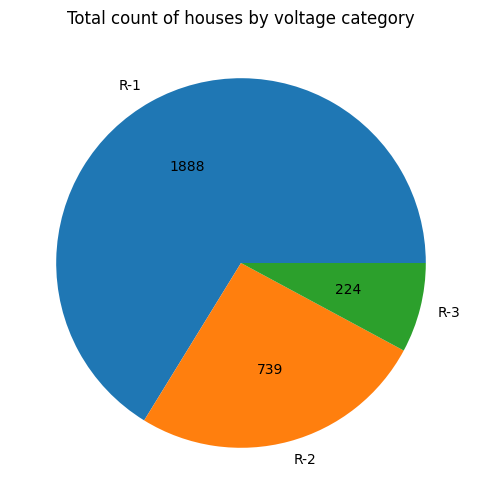

In [1418]:
voltage_category_group = house.groupby("voltage_category")["id"].count()
print(voltage_category_group)
voltage_category_group.plot(kind="pie",    
                            autopct=lambda p: '{:.0f}'.format(p * house.groupby("voltage_category")["id"].count().sum() / 100),  # Display actual counts
                            figsize=(6, 6),
                            ylabel='',
                            legend=False,
                            xlabel="Voltage"
)
plt.title("Total count of houses by voltage category")
plt.show()

### Drop the `id` column as it is not needed anymore, and get top 5 biggest `building_area` in the dataset. Get the mean `price` of the top 5 largest `building_area` data

In [1419]:
house = house.drop(columns=["id"])
top5_area = house.sort_values("building_area", ascending=False).head(5)
top5_area['price'].mean()

62000000000.0

### Conduct an analysis of the difference of house prices created before the year 2000 and after the year 2000. Show the result with visualization.

Average house price created before the year 2000: 10905526315.789474
Average house price created after the year 2000: 3785341272.6626377


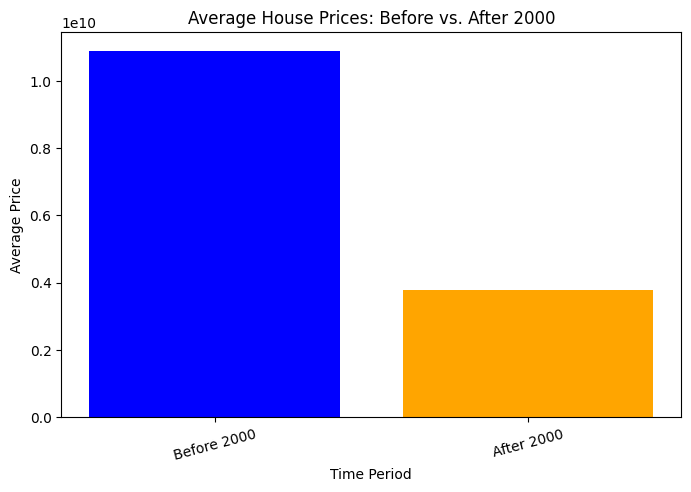

In [1420]:
before_2000_houses = house[house['year'] < 2000]
after_2000_houses = house[house['year'] >= 2000]

print("Average house price created before the year 2000:", before_2000_houses['price'].mean())
print("Average house price created after the year 2000:", after_2000_houses['price'].mean())

average_prices = [before_2000_houses['price'].mean(), after_2000_houses['price'].mean()]
categories = ['Before 2000', 'After 2000']

plt.figure(figsize=(8, 5))
plt.bar(categories, average_prices, color=['blue', 'orange'])
plt.title('Average House Prices: Before vs. After 2000')
plt.xlabel('Time Period')
plt.ylabel('Average Price')
plt.xticks(rotation=15) 

plt.show()

# v. Feature Engineering

# Split X (features) and y (target)

In [1421]:
X = house.drop(['price'], axis=1)
y = house.price

In [1422]:
X.head()

,area,city,latitude,longitude,property_type,bedrooms,bathrooms,land_area,building_area,floors,maid_bedrooms,maid_bathrooms,certificate,voltage,building_age,year,condition,garage,carport,voltage_category
0,Summarecon Bekasi,Bekasi,-6.22,106.99,rumah,4.00,4.00,239.00,272.00,2.00,0.00,1.00,shm - sertifikat hak milik,4400,5.00,"2,017.00",bagus,0,0,R-2
1,Summarecon Bekasi,Bekasi,-6.22,106.99,rumah,3.00,2.00,55.00,69.00,2.00,0.00,0.00,hgb - hak guna bangunan,2200,6.00,"2,016.00",bagus,0,1,R-1
2,Summarecon Bekasi,Bekasi,-6.22,106.99,rumah,3.00,3.00,119.00,131.00,2.00,1.00,1.00,hgb - hak guna bangunan,2200,1.00,"2,021.00",bagus,1,1,R-1
3,Summarecon Bekasi,Bekasi,-6.22,106.99,rumah,3.00,3.00,180.00,174.00,2.00,1.00,1.00,shm - sertifikat hak milik,3500,6.00,"2,016.00",bagus sekali,1,0,R-2
4,Summarecon Bekasi,Bekasi,-6.22,106.99,rumah,4.00,3.00,328.00,196.00,2.00,1.00,1.00,shm - sertifikat hak milik,3500,9.00,"2,013.00",bagus,1,1,R-2


In [1423]:
y.head()

0   2,990,000,000.00
1   1,270,000,000.00
2   1,950,000,000.00
3   3,300,000,000.00
4   4,500,000,000.00
Name: price, dtype: float64

## Split between Train and Test

In [1424]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=38)

print('train size:', X_train.shape)
print('test size:', X_test.shape)
print(X_train)

train size: (2138, 20)
test size: (713, 20)
                area       city  latitude  longitude property_type  bedrooms  \
1292        Cinangka      Depok     -6.37     106.76         rumah      2.00   
2504          Pinang  Tangerang     -6.21     106.66         rumah      2.00   
1508        Sawangan      Depok     -6.40     106.77         rumah      4.00   
476      Serang Baru     Bekasi     -6.40     107.12         rumah      2.00   
281     Bekasi Utara     Bekasi     -6.21     107.01         rumah      4.00   
...              ...        ...       ...        ...           ...       ...   
2785          Ciater  Tangerang     -6.32     106.69         rumah      3.00   
1282        Cinangka      Depok     -6.37     106.76         rumah      2.00   
316   Kemang Pratama     Bekasi     -6.27     106.99         rumah      4.00   
1491        Sawangan      Depok     -6.40     106.77         rumah      1.00   
53              Setu     Bekasi     -6.36     107.03         rumah      2.00

In [1425]:
house.shape

(2851, 21)

# Handling Outliers

In [1426]:
numerical_df = X_train.select_dtypes(include=['number'])

skewness = numerical_df.skew()

print("Skewness of numerical columns:")
for column, value in skewness.items():
  print(f"{column}: {value:.4f}")

Skewness of numerical columns:
latitude: -0.5413
longitude: 3.2103
bedrooms: 16.1096
bathrooms: 14.9010
land_area: 10.8909
building_area: 4.2024
floors: 0.3845
maid_bedrooms: 1.5533
maid_bathrooms: 1.2482
voltage: 6.2449
building_age: 2.9689
year: -2.9689
garage: 0.1899
carport: -1.7916


### Cap columns with outliers, as we have many columns with outlier, we don't want to trim them.

In [1427]:
winsoriser_fare = Winsorizer(capping_method='gaussian',
                             tail='both',
                             fold=3,
                             variables=['bedrooms', 'bathrooms', 'land_area', 'building_area', 'voltage', 'building_age', 'longitude'],
                             missing_values="ignore")

X_train = winsoriser_fare.fit_transform(X_train)
X_test = winsoriser_fare.transform(X_test)
print(X_train.shape)
print(X_test.shape)

(2138, 20)
(713, 20)


In [1428]:
numerical_df = X_train.select_dtypes(include=['number'])

skewness = numerical_df.skew()

print("Skewness of numerical columns:")
for column, value in skewness.items():
  print(f"{column}: {value:.4f}")

Skewness of numerical columns:
latitude: -0.5413
longitude: -0.1794
bedrooms: 1.6232
bathrooms: 1.3832
land_area: 3.3500
building_area: 2.0555
floors: 0.3845
maid_bedrooms: 1.5533
maid_bathrooms: 1.2482
voltage: 2.5398
building_age: 1.6501
year: -2.9689
garage: 0.1899
carport: -1.7916


# Handling Missing Values

In [1429]:
X_train.isna().sum()

area                 0
city                 0
latitude             0
longitude            0
property_type        0
bedrooms            19
bathrooms           12
land_area            0
building_area        0
floors               1
maid_bedrooms        0
maid_bathrooms       0
certificate         74
voltage              0
building_age         0
year                 0
condition            0
garage               0
carport              0
voltage_category     0
dtype: int64

In [1430]:
X_test.isna().sum()

area                 0
city                 0
latitude             0
longitude            0
property_type        0
bedrooms             7
bathrooms            9
land_area            0
building_area        0
floors               0
maid_bedrooms        0
maid_bathrooms       0
certificate         21
voltage              0
building_age         0
year                 0
condition            0
garage               0
carport              0
voltage_category     0
dtype: int64

### Fill the columns that have missing values. Fill the `certificate` column with its mode, as it is a categorical column. Fill `bedrooms`, `bathrooms` and `floors` with median, as they are skewed.

In [1431]:
X_train['certificate'] = X_train['certificate'].fillna(X_train['certificate'].mode()[0])
X_test['certificate'] = X_test['certificate'].fillna(X_train['certificate'].mode()[0])
X_train['bedrooms'] = X_train['bedrooms'].fillna(X_train['bedrooms'].median())
X_test['bedrooms'] = X_test['bedrooms'].fillna(X_train['bedrooms'].median())
X_train['bathrooms'] = X_train['bathrooms'].fillna(X_train['bathrooms'].median())
X_test['bathrooms'] = X_test['bathrooms'].fillna(X_train['bathrooms'].median())
X_train['floors'] = X_train['floors'].fillna(X_train['floors'].median())
X_test['floors'] = X_test['floors'].fillna(X_train['floors'].median())

In [1432]:
X_train.isna().sum()

area                0
city                0
latitude            0
longitude           0
property_type       0
bedrooms            0
bathrooms           0
land_area           0
building_area       0
floors              0
maid_bedrooms       0
maid_bathrooms      0
certificate         0
voltage             0
building_age        0
year                0
condition           0
garage              0
carport             0
voltage_category    0
dtype: int64

In [1433]:
X_test.isna().sum()

area                0
city                0
latitude            0
longitude           0
property_type       0
bedrooms            0
bathrooms           0
land_area           0
building_area       0
floors              0
maid_bedrooms       0
maid_bathrooms      0
certificate         0
voltage             0
building_age        0
year                0
condition           0
garage              0
carport             0
voltage_category    0
dtype: int64

### All categorical columns

In [1434]:
category_columns = ['property_type', 'city', 'garage', 'carport', 'certificate', 'voltage_category']
ordinal_category_columns = ['condition']
X_train[category_columns + ordinal_category_columns]

,property_type,city,garage,carport,certificate,voltage_category,condition
1292,rumah,Depok,0,1,shm - sertifikat hak milik,R-1,baru
2504,rumah,Tangerang,0,1,shm - sertifikat hak milik,R-1,bagus
1508,rumah,Depok,0,1,shm - sertifikat hak milik,R-1,baru
476,rumah,Bekasi,0,1,shm - sertifikat hak milik,R-1,bagus
281,rumah,Bekasi,0,0,shm - sertifikat hak milik,R-1,bagus
...,...,...,...,...,...,...,...
2785,rumah,Tangerang,1,1,shm - sertifikat hak milik,R-2,baru
1282,rumah,Depok,1,1,shm - sertifikat hak milik,R-1,baru
316,rumah,Bekasi,1,1,shm - sertifikat hak milik,R-2,bagus
1491,rumah,Depok,0,1,shm - sertifikat hak milik,R-1,bagus


### All numerical columns

In [1435]:
num_columns = ['latitude', 'longitude', 'bedrooms', 'bathrooms', 'land_area', 'building_area', 'floors', 'maid_bedrooms', 'maid_bathrooms', 'voltage', 'building_age', 'year']
X_train[num_columns]

,latitude,longitude,bedrooms,bathrooms,land_area,building_area,floors,maid_bedrooms,maid_bathrooms,voltage,building_age,year
1292,-6.37,106.76,2.00,1.00,72.00,48.00,1.00,0.00,0.00,"1,300.00",0.00,"2,022.00"
2504,-6.21,106.66,2.00,2.00,90.00,95.00,2.00,0.00,0.00,"2,200.00",8.00,"2,014.00"
1508,-6.40,106.77,4.00,4.00,124.00,135.00,2.00,0.00,0.00,"2,200.00",0.00,"2,022.00"
476,-6.40,107.12,2.00,1.00,100.00,45.00,1.00,0.00,0.00,"1,300.00",0.00,"2,022.00"
281,-6.21,107.01,4.00,2.00,210.00,230.00,2.00,0.00,0.00,"2,200.00",6.00,"2,016.00"
...,...,...,...,...,...,...,...,...,...,...,...,...
2785,-6.32,106.69,3.00,3.00,61.00,80.00,2.00,0.00,0.00,"3,300.00",0.00,"2,022.00"
1282,-6.37,106.76,2.00,1.00,85.00,50.00,1.00,0.00,0.00,"1,300.00",0.00,"2,022.00"
316,-6.27,106.99,4.00,2.00,220.00,200.00,2.00,1.00,1.00,"4,400.00",12.00,"2,010.00"
1491,-6.40,106.77,1.00,1.00,72.00,43.00,1.00,1.00,0.00,"1,300.00",4.00,"2,018.00"


Drop column `area` because of two reasons:
- High cardinality
- The `area` column can be represented with `city`

In [1436]:
X_train.drop(columns=["area"], inplace=True)
X_test.drop(columns=["area"], inplace=True)

# vi. Model Definition

### Use Ordinal Encoder to transform `condition` as it is an ordinal category.

In [1437]:
condition_category = ['butuh renovasi', 'sudah renovasi', 'bagus', 'bagus sekali', 'baru']
ordinal_encoder = OrdinalEncoder(categories=[condition_category])

ordinal_encoder.fit(X_train[ordinal_category_columns])
X_train['condition'] = ordinal_encoder.transform(X_train[ordinal_category_columns])
X_test['condition'] = ordinal_encoder.transform(X_test[ordinal_category_columns])

### Use One Hot Encoder to transform `property_type`, `city`, `certificate`, `garage`, `carport` and `voltage_category`.

In [1438]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
category_one_hot_encoder = category_columns
one_hot_encoder.fit(X_train[category_one_hot_encoder])
one_hot_encoder.get_feature_names_out()

array(['property_type_rumah', 'city_Bekasi', 'city_Bogor', 'city_Depok',
       'city_Jakarta Barat', 'city_Jakarta Pusat', 'city_Jakarta Selatan',
       'city_Jakarta Timur', 'city_Jakarta Utara', 'city_Tangerang',
       'garage_0', 'garage_1', 'carport_0', 'carport_1',
       'certificate_hgb - hak guna bangunan',
       'certificate_lainnya (ppjb,girik,adat,dll)',
       'certificate_shm - sertifikat hak milik', 'voltage_category_R-1',
       'voltage_category_R-2', 'voltage_category_R-3'], dtype=object)

### Show the encoded value of all categorical columns

In [1439]:
X_train_cat = pd.DataFrame(one_hot_encoder.transform(X_train[category_one_hot_encoder]), columns=one_hot_encoder.get_feature_names_out())
X_test_cat = pd.DataFrame(one_hot_encoder.transform(X_test[category_one_hot_encoder]), columns=one_hot_encoder.get_feature_names_out())
X_train_cat.head()

,property_type_rumah,city_Bekasi,city_Bogor,city_Depok,city_Jakarta Barat,city_Jakarta Pusat,city_Jakarta Selatan,city_Jakarta Timur,city_Jakarta Utara,city_Tangerang,garage_0,garage_1,carport_0,carport_1,certificate_hgb - hak guna bangunan,"certificate_lainnya (ppjb,girik,adat,dll)",certificate_shm - sertifikat hak milik,voltage_category_R-1,voltage_category_R-2,voltage_category_R-3
0,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
1,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
2,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
3,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
4,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00


### Create a new X_train and X_test variable to combine the numerical and the encoded categorical data

In [1440]:
X_train.drop(columns=category_one_hot_encoder, axis=1, inplace=True)
X_test.drop(columns=category_one_hot_encoder, axis=1, inplace=True)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_train_new = pd.concat([X_train, X_train_cat], axis=1)
X_test_new = pd.concat([X_test, X_test_cat], axis=1)
X_train_new

,latitude,longitude,bedrooms,bathrooms,land_area,building_area,floors,maid_bedrooms,maid_bathrooms,voltage,...,garage_0,garage_1,carport_0,carport_1,certificate_hgb - hak guna bangunan,"certificate_lainnya (ppjb,girik,adat,dll)",certificate_shm - sertifikat hak milik,voltage_category_R-1,voltage_category_R-2,voltage_category_R-3
0,-6.37,106.76,2.00,1.00,72.00,48.00,1.00,0.00,0.00,"1,300.00",...,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
1,-6.21,106.66,2.00,2.00,90.00,95.00,2.00,0.00,0.00,"2,200.00",...,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
2,-6.40,106.77,4.00,4.00,124.00,135.00,2.00,0.00,0.00,"2,200.00",...,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
3,-6.40,107.12,2.00,1.00,100.00,45.00,1.00,0.00,0.00,"1,300.00",...,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
4,-6.21,107.01,4.00,2.00,210.00,230.00,2.00,0.00,0.00,"2,200.00",...,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2133,-6.32,106.69,3.00,3.00,61.00,80.00,2.00,0.00,0.00,"3,300.00",...,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00
2134,-6.37,106.76,2.00,1.00,85.00,50.00,1.00,0.00,0.00,"1,300.00",...,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
2135,-6.27,106.99,4.00,2.00,220.00,200.00,2.00,1.00,1.00,"4,400.00",...,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00
2136,-6.40,106.77,1.00,1.00,72.00,43.00,1.00,1.00,0.00,"1,300.00",...,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00


### Encode all the numerical columns data. Use MinMaxScaler, because the numerical data has different digits, so that the model will be fair.

In [1441]:
scaler = MinMaxScaler()
scaler.fit(X_train_new[num_columns])
X_train_new[num_columns]= scaler.transform(X_train_new[num_columns])
X_test_new[num_columns]= scaler.transform(X_test_new[num_columns])

In [1442]:
X_train_new.head()

,latitude,longitude,bedrooms,bathrooms,land_area,building_area,floors,maid_bedrooms,maid_bathrooms,voltage,...,garage_0,garage_1,carport_0,carport_1,certificate_hgb - hak guna bangunan,"certificate_lainnya (ppjb,girik,adat,dll)",certificate_shm - sertifikat hak milik,voltage_category_R-1,voltage_category_R-2,voltage_category_R-3
0,0.66,0.41,0.12,0.00,0.05,0.03,0.00,0.00,0.00,0.07,...,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
1,0.86,0.30,0.12,0.13,0.06,0.10,0.25,0.00,0.00,0.14,...,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
2,0.63,0.42,0.36,0.38,0.09,0.15,0.25,0.00,0.00,0.14,...,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
3,0.63,0.81,0.12,0.00,0.07,0.03,0.00,0.00,0.00,0.07,...,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
4,0.87,0.69,0.36,0.13,0.16,0.28,0.25,0.00,0.00,0.14,...,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00


# vii. Model Training

### Use LinearRegression model

In [1443]:
linear_regression = LinearRegression()
linear_regression.fit(X_train_new, y_train)

LinearRegression()

# viii. Model Evaluation

In [1444]:
print(f'intercept: {linear_regression.intercept_}')
print(f'coef: {linear_regression.coef_}')

intercept: -1.797527651330624e+23
coef: [ 5.04072333e+09 -2.45351999e+09 -3.88559076e+09 -3.39431911e+08
  2.07851475e+10  8.27042520e+09 -2.07185470e+09 -6.07446194e+08
  4.84492421e+09  2.06353445e+10  3.42440348e+08  4.70364541e+09
  6.85477160e+07 -4.70856989e+20 -2.51257932e+21 -2.51257932e+21
 -2.51257932e+21 -2.51257932e+21 -2.51257932e+21 -2.51257932e+21
 -2.51257932e+21 -2.51257932e+21 -2.51257932e+21  9.70895274e+21
  9.70895274e+21  4.89595200e+21  4.89595200e+21 -1.57859659e+22
 -1.57859659e+22 -1.57859659e+22  1.83917263e+23  1.83917263e+23
  1.83917263e+23]


### Predict with the LinearRegression model

In [1445]:
y_pred_train = linear_regression.predict(X_train_new)
y_pred_test = linear_regression.predict(X_test_new)
y_pred_train

array([ 6.71088640e+08,  1.87904819e+09,  2.18103808e+09, ...,
        2.91923558e+09,  3.35544320e+08, -1.54350387e+09])

### The MAE train is 2590865551.715622, it means the prediction can be (more or less than) ± 2590865551.715622 from the actual value.

### The MAE test is 2067587022.451613, it means the test prediction can be (more or less than) ± 2067587022.451613 from the actual value.

In [1446]:
print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}')
print(f'MAE test: {mean_absolute_error(y_test, y_pred_test)}')

MAE train: 1982438344.9504209
MAE test: 2751227331.321178


In [1447]:
print(f'R2 score train: {linear_regression.score(X_train_new, y_train)}')
print(f'R2 score test: {linear_regression.score(X_test_new, y_test)}')

R2 score train: 0.5738934356539478
R2 score test: 0.0791207884558004


# ix. Model Saving

### Save all the important files that can be used for Model Inference

In [1448]:
with open('model_linear.pkl', 'wb') as model_file:
  pickle.dump(linear_regression, model_file)

with open('model_scaler.pkl', 'wb') as scaler_file:
  pickle.dump(scaler, scaler_file)

with open('one_hot_encoder.pkl', 'wb') as one_hot_encoder_file:
  pickle.dump(one_hot_encoder, one_hot_encoder_file)

with open('ordinal_encoder.pkl', 'wb') as ordinal_encoder_file:
  pickle.dump(ordinal_encoder, ordinal_encoder_file)

with open('num_col.txt', 'w') as num_col_file:
  json.dump(num_columns, num_col_file)

with open('cat_col.txt', 'w') as cat_col_file:
  json.dump(category_columns, cat_col_file)

with open('ordinal_cat_col.txt', 'w') as cat_col_file:
  json.dump(ordinal_category_columns, cat_col_file)